# User Satisfaction Analysis

### Import packages

In [2]:
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
import numpy as np
import sys, os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
sys.path.append(os.path.abspath(os.path.join('../src')))

In [44]:

from data_loader import run_sql_query, populate_dataframe_to_database, load_data
from data_cleaning_utils import DataCleaningUtil
from plot_utils import PlotUtil

cleaning_utils = DataCleaningUtil()
plot_utls = PlotUtil()

### Load engagement and experience models and dataframes

In [5]:
engagement_df = pd.read_csv("../data/tellco_user_engagement_data.csv")
experience_df = pd.read_csv("../data/tellco_user_experience_data.csv")

In [6]:
experience_df.columns

Index(['msisdn_number', 'cluster', 'total_avg_bearer_tp_kbps',
       'total_avg_rtt_dl_ms', 'total_tcp_dl_retrans_vol_bytes'],
      dtype='object')

In [7]:
with open("../models/tellco_user_engagement.pkl", "rb") as f:
    model_user_engagement = pickle.load(f)

In [8]:
with open("../models/tellco_user_experience.pkl", "rb") as f:
    model_user_experience = pickle.load(f)

### Engagement score to each user

In [9]:
# Use the clustering model to predict the clusters for your data
engagement_df['cluster'] = model_user_engagement.predict(engagement_df[['xdr_sessions', 'dur_ms', 'total_data_bytes']])

# Calculate the average engagement for each cluster
cluster_engagement = engagement_df.groupby('cluster')['xdr_sessions', 'dur_ms', 'total_data_bytes'].mean()

# Calculate an overall engagement score for each cluster (you can customize this based on your needs)
cluster_engagement['engagement_score'] = cluster_engagement.sum(axis=1)

# Identify the least engaged cluster
least_engaged_cluster = cluster_engagement['engagement_score'].idxmin()

print(f"The least engaged cluster is: {least_engaged_cluster}")


The least engaged cluster is: 0


/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/tmp/ipykernel_70263/3818933782.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_engagement = engagement_df.groupby('cluster')['xdr_sessions', 'dur_ms', 'total_data_bytes'].mean()


In [10]:
engagement_df_formatted = engagement_df.set_index('msisdn_number')[
    ['xdr_sessions', 'dur_ms', 'total_data_bytes']]
engagement_df_formatted.head()

xdr_sessions    dur_ms  total_data_bytes
msisdn_number                                          
3.360167e+10            3.5  326892.5      1.604650e+09
3.360171e+10            1.0   38503.0      3.396170e+08
3.360171e+10            1.0   52478.0      9.006109e+08
3.360171e+10            2.0  120298.0      1.587337e+09
3.360171e+10            1.0  176022.0      1.783307e+08

In [11]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(engagement_df_formatted)
scaled_data

array([[ 3.28881741,  2.32020199,  2.38118731],
       [-0.54939094, -1.05245656, -0.81904575],
       [-0.54939094, -0.88902168,  0.60013557],
       ...,
       [-0.54939094, -0.73035828, -0.46121225],
       [-0.54939094,  1.00239059, -0.67956342],
       [ 3.28881741,  2.32020199,  2.38118731]])

In [12]:
normalized_data = normalize(scaled_data)
normalized_data

array([[ 0.70326378,  0.49614004,  0.50918083],
       [-0.38090376, -0.72968924, -0.56786084],
       [-0.45587466, -0.7376941 ,  0.49798164],
       ...,
       [-0.5366696 , -0.71344658, -0.45053271],
       [-0.41313151,  0.75377862, -0.51101874],
       [ 0.70326378,  0.49614004,  0.50918083]])

In [13]:
distance = model_user_engagement.fit_transform(normalized_data)
distance_from_less_engaged_cluster = list(
    map(lambda x: x[least_engaged_cluster], distance))

engagement_df['engagement_score'] = distance_from_less_engaged_cluster
engagement_df.head()

/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


msisdn_number  cluster  xdr_sessions    dur_ms  total_data_bytes  \
0   3.360167e+10        0           3.5  326892.5      1.604650e+09   
1   3.360171e+10        0           1.0   38503.0      3.396170e+08   
2   3.360171e+10        0           1.0   52478.0      9.006109e+08   
3   3.360171e+10        0           2.0  120298.0      1.587337e+09   
4   3.360171e+10        0           1.0  176022.0      1.783307e+08   

   engagement_score  
0          0.221090  
1          1.753012  
2          1.500535  
3          0.641750  
4          1.619763

In [14]:
engagement_df.to_csv('../data/tellco_user_engagement_score_data.csv')

### Experience score to each user

In [15]:
# Use the clustering model to predict the clusters for your data
experience_df['cluster'] = model_user_experience.predict(experience_df[[ 
    'total_avg_bearer_tp_kbps', 'total_avg_rtt_dl_ms', 'total_tcp_dl_retrans_vol_bytes']])

# Calculate the average engagement for each cluster
cluster_experience = experience_df.groupby('cluster')[
    'total_avg_bearer_tp_kbps', 'total_avg_rtt_dl_ms', 'total_tcp_dl_retrans_vol_bytes'].mean()

# Calculate an overall engagement score for each cluster (you can customize this based on your needs)
cluster_experience['experience_score'] = cluster_experience.sum(axis=1)

# Identify the least engaged cluster
least_experience_cluster = cluster_experience['experience_score'].idxmin()

print(f"The least experienced cluster is: {least_engaged_cluster}")


The least experienced cluster is: 0


/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/tmp/ipykernel_70263/3003484912.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_experience = experience_df.groupby('cluster')[


In [16]:
experience_df_formatted = experience_df.set_index('msisdn_number')[
    ['total_avg_bearer_tp_kbps', 'total_avg_rtt_dl_ms', 'total_tcp_dl_retrans_vol_bytes']]
experience_df_formatted.head()

total_avg_bearer_tp_kbps  total_avg_rtt_dl_ms  \
msisdn_number                                                  
3.360167e+10                 61126.6875                239.0   
3.360171e+10                    70.0000                115.0   
3.360171e+10                  9792.0000                128.0   
3.360171e+10                 50605.2500                238.0   
3.360171e+10                   117.0000                 34.0   

               total_tcp_dl_retrans_vol_bytes  
msisdn_number                                  
3.360167e+10                     1.121739e+07  
3.360171e+10                     6.587000e+03  
3.360171e+10                     6.192340e+05  
3.360171e+10                     1.121739e+07  
3.360171e+10                     5.784310e+05

In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(experience_df_formatted)
scaled_data

array([[ 2.35236657,  2.80486663,  2.54301596],
       [-0.67642078,  0.57795945, -0.75763339],
       [-0.19414977,  0.81142553, -0.5772598 ],
       ...,
       [-0.27351961, -0.96650843, -0.75558631],
       [-0.67914912, -1.11017986,  1.16788898],
       [ 2.35236657,  2.80486663,  2.54301596]])

In [18]:
normalized_data = normalize(scaled_data)
normalized_data

array([[ 0.5277518 ,  0.62926987,  0.57052386],
       [-0.57883754,  0.49458065, -0.64833409],
       [-0.19136329,  0.79977979, -0.56897485],
       ...,
       [-0.21761001, -0.76894635, -0.60113841],
       [-0.38838922, -0.63488545,  0.66788792],
       [ 0.5277518 ,  0.62926987,  0.57052386]])

In [19]:
distance = model_user_experience.fit_transform(normalized_data)
distance_from_less_experienced_cluster = list(
    map(lambda x: x[least_experience_cluster], distance))

experience_df['experience_score'] = distance_from_less_experienced_cluster
experience_df.head()


/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


msisdn_number  cluster  total_avg_bearer_tp_kbps  total_avg_rtt_dl_ms  \
0   3.360167e+10        0                61126.6875                239.0   
1   3.360171e+10        0                   70.0000                115.0   
2   3.360171e+10        0                 9792.0000                128.0   
3   3.360171e+10        0                50605.2500                238.0   
4   3.360171e+10        0                  117.0000                 34.0   

   total_tcp_dl_retrans_vol_bytes  experience_score  
0                    1.121739e+07          0.668851  
1                    6.587000e+03          1.337420  
2                    6.192340e+05          1.069035  
3                    1.121739e+07          0.730359  
4                    5.784310e+05          1.582569

In [20]:
experience_df.to_csv('../data/tellco_user_experience_score_data.csv')

#### The satisfaction score (engagement + experience) & the top 10 satisfied customer

In [21]:
merged_df = pd.merge(engagement_df, experience_df, on='msisdn_number')
merged_df['satisfaction_score'] = (
    merged_df['engagement_score'] + merged_df['experience_score'])/2
merged_df.head(5)

msisdn_number  cluster_x  xdr_sessions    dur_ms  total_data_bytes  \
0   3.360167e+10          0           3.5  326892.5      1.604650e+09   
1   3.360171e+10          0           1.0   38503.0      3.396170e+08   
2   3.360171e+10          0           1.0   52478.0      9.006109e+08   
3   3.360171e+10          0           2.0  120298.0      1.587337e+09   
4   3.360171e+10          0           1.0  176022.0      1.783307e+08   

   engagement_score  cluster_y  total_avg_bearer_tp_kbps  total_avg_rtt_dl_ms  \
0          0.221090          0                61126.6875                239.0   
1          1.753012          0                   70.0000                115.0   
2          1.500535          0                 9792.0000                128.0   
3          0.641750          0                50605.2500                238.0   
4          1.619763          0                  117.0000                 34.0   

   total_tcp_dl_retrans_vol_bytes  experience_score  satisfaction_score  
0                    1.121739e+07          0.668851            0.444971  
1                    6.587000e+03          1.337420            1.545216  
2                    6.192340e+05          1.069035            1.284785  
3                    1.121739e+07          0.730359            0.686055  
4                    5.784310e+05          1.582569            1.601166

In [22]:
satisfaction_df = merged_df[['msisdn_number', 'engagement_score',
                        'experience_score', 'satisfaction_score']]
satisfaction_df = satisfaction_df.set_index('msisdn_number')
satisfaction_df.head(5)

engagement_score  experience_score  satisfaction_score
msisdn_number                                                        
3.360167e+10           0.221090          0.668851            0.444971
3.360171e+10           1.753012          1.337420            1.545216
3.360171e+10           1.500535          1.069035            1.284785
3.360171e+10           0.641750          0.730359            0.686055
3.360171e+10           1.619763          1.582569            1.601166

In [23]:
sorted_satisfaction = satisfaction_df.sort_values(
    'satisfaction_score', ascending=False)
top_10_satisfaction = sorted_satisfaction['satisfaction_score'].head(10)

In [24]:
plot_utls.hist(top_10_satisfaction)

### Regression model to predict the satisfaction score of a customer. 

In [25]:
# Define features (X) and target variable (y)
X = satisfaction_df[['engagement_score', 'experience_score']]
y = satisfaction_df['satisfaction_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)


LinearRegression()

In [27]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 4.988663353238458e-32
R-squared: 1.0


### K-means (k=2) on the engagement & the experience score

In [28]:
satisfaction_df_kmeans = merged_df[[
    'msisdn_number', 
    'engagement_score',
    'experience_score']].copy()
satisfaction_df_kmeans = satisfaction_df_kmeans.set_index('msisdn_number')
satisfaction_df_kmeans.head()

engagement_score  experience_score
msisdn_number                                    
3.360167e+10           0.221090          0.668851
3.360171e+10           1.753012          1.337420
3.360171e+10           1.500535          1.069035
3.360171e+10           0.641750          0.730359
3.360171e+10           1.619763          1.582569

<Axes: >

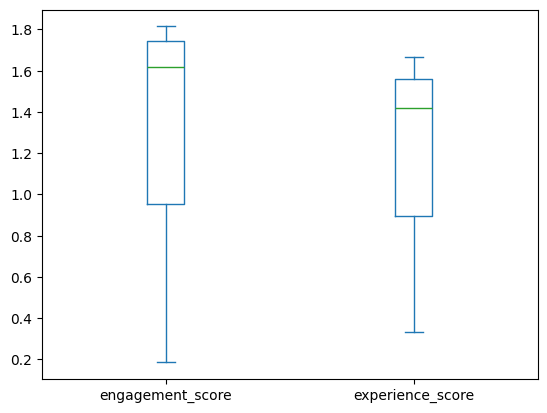

In [29]:
satisfaction_df_kmeans.plot.box()

In [30]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(satisfaction_df_kmeans)
scaled_array
pd.DataFrame(scaled_array).head(5)

0         1
0 -2.111960 -1.462722
1  0.763485  0.268737
2  0.289581 -0.426328
3 -1.322374 -1.303428
4  0.513375  0.903623

In [31]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

0         1
0 -0.822084 -0.569367
1  0.943272  0.332020
2  0.561883 -0.827216
3 -0.712190 -0.701987
4  0.493975  0.869476

In [32]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_normalized)
kmeans.labels_

/home/babi/anaconda3/envs/tenx_week1/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([1, 0, 1, ..., 0, 0, 1], dtype=int32)

In [33]:
satisfaction_df_kmeans.insert(0, 'cluster', kmeans.labels_)
satisfaction_df_kmeans.head(5)

cluster  engagement_score  experience_score
msisdn_number                                             
3.360167e+10         1          0.221090          0.668851
3.360171e+10         0          1.753012          1.337420
3.360171e+10         1          1.500535          1.069035
3.360171e+10         1          0.641750          0.730359
3.360171e+10         0          1.619763          1.582569

In [34]:
satisfaction_df_kmeans['cluster'].value_counts()

0    51723
1    38315
Name: cluster, dtype: int64

In [35]:
plot_utls.plot_scatter_cluster(satisfaction_df_kmeans,
                            x_column='engagement_score',
                            y_column='experience_score',
                            color_column='cluster',
                            title='Scatter Plot of User Satisfaction Metrics')


In [36]:
satisfaction_df.reset_index(inplace=True)
satisfaction_df.head()

msisdn_number  engagement_score  experience_score  satisfaction_score
0   3.360167e+10          0.221090          0.668851            0.444971
1   3.360171e+10          1.753012          1.337420            1.545216
2   3.360171e+10          1.500535          1.069035            1.284785
3   3.360171e+10          0.641750          0.730359            0.686055
4   3.360171e+10          1.619763          1.582569            1.601166

In [37]:
satisfaction_df.to_csv('../data/user_satisfaction.csv')

#### Aggregate the average satisfaction & experience score per cluster. 

In [38]:
satisfaction_df_kmeans.groupby('cluster').agg(
    {'engagement_score': 'sum', 'experience_score': 'sum'})

engagement_score  experience_score
cluster                                    
0            84539.969881      77236.231977
1            36674.398565      33839.390666

- Cluster 1 has higher Engagement and satisfaction score. 
- Cluster 2 has vert low expirience score but higher engagement score.

#### Export your final table containing all user id + engagement, experience & satisfaction scores

In [46]:
connection_params = {
    "host": "localhost",
    "user": "birehan",
    "password": "password",
    "port": "5432",
    "database": "tellco_db"  # Change to your desired database name
}

table_name = "public.user_satisfactions"

create_table_query =  '''CREATE TABLE public.user_satisfactions (
    "msisdn_number" double precision,
    "engagement_score" double precision,
    "experience_score" double precision,
    "satisfaction_score" double precision
);'''
file_path = "../data/user_satisfaction.csv"


get_statisfaction_query = '''select * from public.user_satisfactions;'''

In [40]:
run_sql_query(connection_params, create_table_query)

2023-12-15 05:35:27,792:logger:Error running SQL query: relation "user_satisfactions" already exists



In [41]:
populate_dataframe_to_database(connection_params, satisfaction_df, table_name)

2023-12-15 05:35:27,871:logger:Successfully connected to the database.


2023-12-15 05:35:30,451:logger:Inserted 90038 rows into the database table public.user_satisfactions.
2023-12-15 05:35:30,452:logger:Database connection closed.


In [47]:
database_satsfaction_df = load_data(connection_params, table_name, file_path)

2023-12-15 05:42:35,688:logger:Successfully fetched data from the database.
2023-12-15 05:42:35,690:logger:Database connection closed.


In [49]:
database_satsfaction_df.head()

msisdn_number  engagement_score  experience_score  satisfaction_score
0   3.360167e+10          0.221090          0.668851            0.444971
1   3.360171e+10          1.753012          1.337420            1.545216
2   3.360171e+10          1.500535          1.069035            1.284785
3   3.360171e+10          0.641750          0.730359            0.686055
4   3.360171e+10          1.619763          1.582569            1.601166